In [ ]:
# Monta o drive do google para receber as imagens armazenadas lá.
# Vai pedir autenticação.
#from google.colab import drive
#drive.mount('/content/drive/')

# -------------------------------------------------------------------------------------
# Exibe algumas subpastas (cat, dog) para termos certeza que está lendo certo.
#import os
#
#image_directory = "/content/drive/MyDrive/Colab_Notebooks/Assets/PetImages/"
#print("Verificando arquivos na pasta...")
#print(os.listdir(image_directory)[:10])  # Mostrar os primeiros 10 arquivos

# -------------------------------------------------------------------------------------
# Exibe alguma imagem para certificar-se que está funcionando
#import cv2
#import matplotlib.pyplot as plt

# Teste com uma imagem real do diretório
#image_path = "/content/drive/MyDrive/Colab_Notebooks/Assets/PetImages/Cat/1.jpg"  # Substitua por um nome válido

# Carregar a imagem
#image = cv2.imread(image_path)  # OpenCV lê em formato BGR
#if image is None:
#    print("Erro ao carregar a imagem! Verifique o caminho.")
#else:
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter para RGB
#    plt.imshow(image)
#    plt.axis("off")
#    plt.show()

#print("Miauuuuu...!")

# -------------------------------------------------------------------------
# Testar a leitura do Tensorflow

#import tensorflow as tf

# Testar carregamento de imagem com TensorFlow
#image = tf.io.read_file(image_path)  # Ler o arquivo
#image = tf.image.decode_jpeg(image, channels=3)  # Decodificar
#image = tf.image.resize(image, (160, 160))  # Ajustar tamanho

#plt.imshow(image.numpy().astype("uint8"))
#plt.axis("off")
#plt.show()

#print("Se viu um gato novamente, o TF leu a imagem corretamente")


In [ ]:
# Pega path onde estou
!pwd
!ls '/content/drive/'

/content
ls: cannot access '/content/drive/': No such file or directory


In [ ]:
# Descompacta os arquivos baixados em:
# https://www.microsoft.com/en-us/download/details.aspx?id=54765
import zipfile
import os

# Caminho para o arquivo ZIP hospedado no Colab
zip_file_path = '/content/drive/MyDrive/Colab_Notebooks/kagglecatsanddogs_5340.zip'

# Diretório onde você quer extrair os arquivos
extraction_path = '/content/drive/MyDrive/Colab_Notebooks/Assets/'

# Verificar se o arquivo zip existe
if os.path.exists(zip_file_path):
    # Criar o diretório de destino, se não existir
    os.makedirs(extraction_path, exist_ok=True)

    # Descompactar o arquivo ZIP
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)  # Extrair para o diretório '/content/drive/MyDrive/Colab Notebooks/Assets/'

    print("Arquivos descompactados com sucesso!")
else:
    print("Arquivo ZIP não encontrado.")



Arquivo ZIP não encontrado.


In [ ]:
# Passo 1: Obter a Base de Imagens
#
import tensorflow as tf

# Diretório onde as imagens foram descompactadas
image_directory = '/content/drive/MyDrive/Colab_Notebooks/Assets/PetImages/'

# Carregar as imagens diretamente do diretório
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    image_size=(160, 160),  # Ajuste o tamanho das imagens conforme necessário
    batch_size=32,          # Tamanho do lote
    validation_split=0.2,   # Usar 20% para validação
    subset="training",      # Subconjunto de treinamento
    seed=123,               # Semente para reprodutibilidade
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    image_size=(160, 160),  # Ajuste o tamanho das imagens conforme necessário
    batch_size=32,          # Tamanho do lote
    validation_split=0.2,   # Usar 20% para validação
    subset="validation",    # Subconjunto de validação
    seed=123,               # Semente para reprodutibilidade
)

# Verificar o sucesso
print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")



Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# Passo 2: Preparar os Dados
#

import tensorflow as tf
import tensorflow_datasets as tfds

# Carregar dataset "cats_vs_dogs"
dataset_dict, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

# Pegar apenas os dados da chave 'train'
dataset = dataset_dict['train']

# Função para normalizar e redimensionar imagens
def format_image(image, label):
    image = tf.image.resize(image, (160, 160))  # Ajusta tamanho
    image = image / 255.0  # Normaliza os valores (0 a 1)
    return image, label

# Aplicar a função de formatação
dataset = dataset.map(format_image)

# Separar em treino e validação
SPLIT_RATIO = 0.8  # 80% treino, 20% validação
total_examples = info.splits['train'].num_examples
train_size = int(SPLIT_RATIO * total_examples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Criar batches
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset preparado com sucesso!")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UWAA1L_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset preparado com sucesso!


In [ ]:
# Passo 3: Carregar Modelo Pré-Treinado
#

# Carregar MobileNetV2 sem a última camada (para Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

# Congelar camadas do modelo base
base_model.trainable = False

# Criar nova camada de saída
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')  # 1 nó (cães vs gatos)

# Construir o modelo final
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    output_layer
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Passo 4: Treinar o Modelo
#

# Separar dados de treino e validação
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = dataset.take(500).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.skip(100).batch(BATCH_SIZE)

# Treinamento
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

print("Treino finalizado!")


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 456s 30s/step - accuracy: 0.6338 - loss: 0.6842 - val_accuracy: 0.9169 - val_loss: 0.2804
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 440s 29s/step - accuracy: 0.9351 - loss: 0.2365 - val_accuracy: 0.9511 - val_loss: 0.1667
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 452s 30s/step - accuracy: 0.9558 - loss: 0.1341 - val_accuracy: 0.9569 - val_loss: 0.1358
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 502s 30s/step - accuracy: 0.9837 - loss: 0.0974 - val_accuracy: 0.9601 - val_loss: 0.1213
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 488s 29s/step - accuracy: 0.9880 - loss: 0.0814 - val_accuracy: 0.9615 - val_loss: 0.1126
Treino finalizado!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


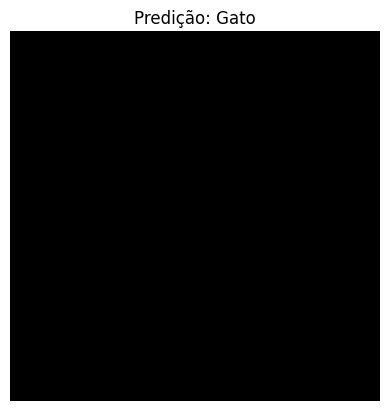

In [ ]:
# Passo 5: Testar o Modelo
#
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_image(image):
    """Redimensiona, normaliza e faz a predição da imagem."""
    image = tf.image.resize(image, (160, 160)) / 255.0  # Ajuste do tamanho e normalização
    image = np.expand_dims(image, axis=0)  # Adiciona dimensão batch
    prediction = model.predict(image)[0][0]  # Obtém o valor de saída
    return "Cachorro" if prediction > 0.5 else "Gato"

# 🔹 Pegando uma amostra do conjunto de validação
for images, labels in val_dataset.take(1):  # Pegando um lote (batch)
    image = images[0].numpy().astype("uint8")  # Pegamos apenas a primeira imagem do lote
    plt.imshow(image)  # Exibe a imagem
    plt.axis("off")  # Remove eixos para melhor visualização
    plt.title(f"Predição: {predict_image(images[0])}")  # Predição do modelo
    plt.show()




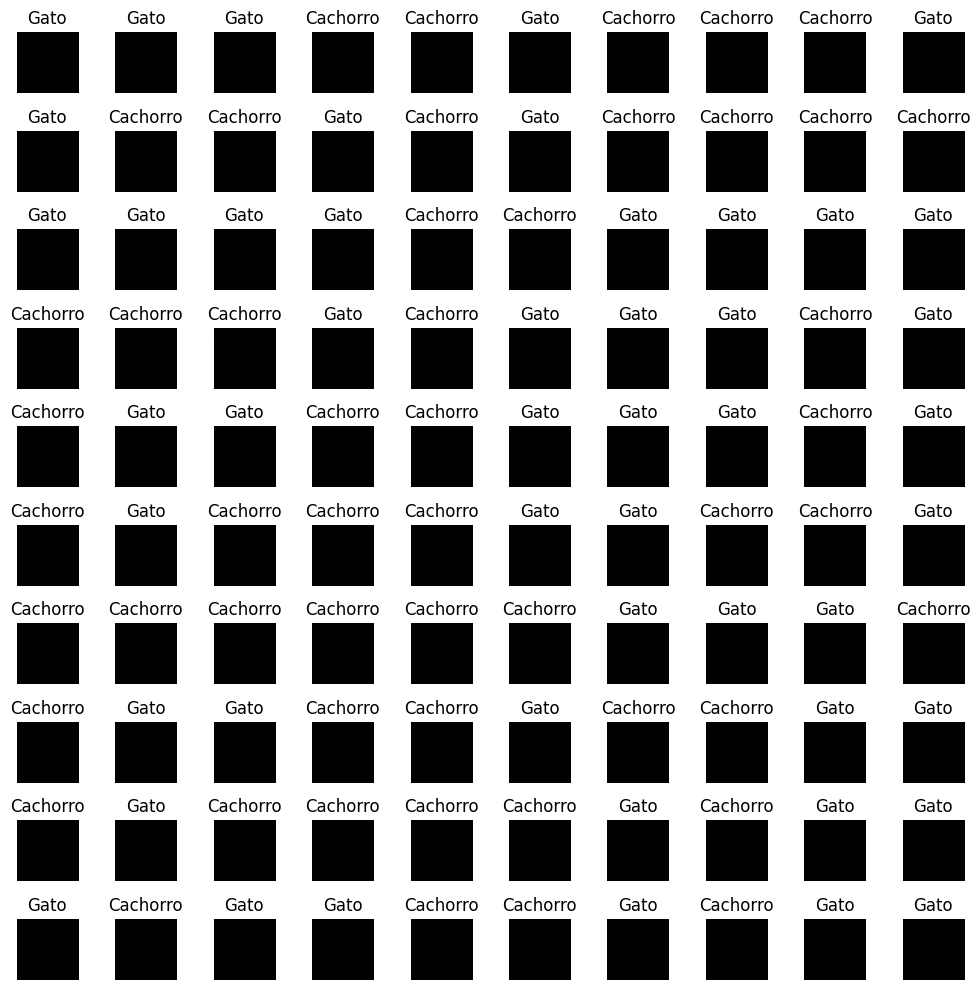

In [ ]:
# Mostrar Algumas Amostras do Dataset
#

import matplotlib.pyplot as plt

# Pegar 100 imagens do dataset de treino
num_samples = 100  # Número de imagens a exibir
samples = list(train_dataset.unbatch().take(num_samples))  # Pega 100 imagens do dataset

# Criar figura
plt.figure(figsize=(10, 10))

# Exibir as amostras
for i, (image, label) in enumerate(samples):
    plt.subplot(10, 10, i + 1)  # Grid 10x10 para exibir 100 imagens
    plt.imshow(image.numpy().astype("uint8"))  # Converter para formato exibível
    plt.title("Gato" if label.numpy() == 0 else "Cachorro")  # Nome da classe
    plt.axis("off")

plt.tight_layout()  # Para ajustar o layout das imagens
plt.show()


